# INF442 Project: Power Consumption Weather
<span style="color:green">Students: </span> *Huu Nguyen Hoang, Gabriel Pereira de Carvalho*

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Python setup](#setup)
- [Task 1: Data preprocessing](#1)
    - [Creating two principal dataframes](#1.1)
    - [Treating missing data](#1.2)
        - [Visualising the missing data](#1.2.1)
        - [Interpolating missing data](#1.2.2)
        - [Winsorizing outliers](#1.2.3)
    - [Merging the two dataframes](#1.3)
- [Task 2: Seasonality detection](#2)
- [Task 3: Distribution of hourly consumption](#3)

<h2 align="center"> <font color='gray'>Python setup</font></h2> <a class="anchor" id="setup"></a>

In [1]:
!pip install -q numpy pandas missingno datetime seaborn matplotlib scipy kneed

import numpy as np
import pandas as pd
import missingno as msno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, kstest

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

<h2 align="center"> <font color='gray'>Task 1: Data preprocessing</font></h2> <a class="anchor" id="1"></a>

<h3 align="center"> <font color='gray'>Creating two principal dataframes</font></h3> <a class="anchor" id="1.1"></a>

Our data folder has four *csv* files with data relative to the household. To facilitate our analysis, we will convert the *csv* files containing data from the household into a single dataframe.

In [2]:
df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
df_2007.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
df_2008.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
df_2009.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2010 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2010.csv',  sep=';')
df_2010.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

#to facilitate preprocessing, we will concatenate the dataframes
df_list = [df_2007, df_2008, df_2009, df_2010]
df_household = pd.concat(df_list)

/tmp/ipykernel_125748/3375055808.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
/tmp/ipykernel_125748/3375055808.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
/tmp/ipykernel_125748/3375055808.py:7: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
/tmp/ipykernel_125748/3375055808.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2010 = pd.read_csv('p1-power-weather/hous

We have a dataframe with all data collected relative to the household. First, let's convert all dates to **DateTime** and all the numeric data from object data-type to float/int data-type:

In [3]:
df_household['date'] = pd.to_datetime(df_household['Date'] + ' ' + df_household['Time'], format='%d/%m/%Y %H:%M:%S')
df_household.drop(['Date', 'Time'], axis=1, inplace=True)

In [4]:
df_household.replace('?', np.nan, inplace=True)

df_household['global_active_power'] = df_household['global_active_power'].astype('float')
df_household['global_reactive_power'] = df_household['global_reactive_power'].astype('float')
df_household['voltage'] = df_household['voltage'].astype('float')
df_household['global_intensity'] = df_household['global_intensity'].astype('float')
df_household['sub_metering_1'] = df_household['sub_metering_1'].astype('float')
df_household['sub_metering_2'] = df_household['sub_metering_2'].astype('float')
df_household['sub_metering_3'] = df_household['sub_metering_3'].astype('float')

df_household.describe(include='all')

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,date
count,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2053259
mean,1.082831e+00,1.236313e-01,2.408333e+02,4.590848e+00,1.120551e+00,1.288581e+00,6.448125e+00,2008-12-13 22:31:27.762031104
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2007-01-01 00:01:00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-23 11:15:30
50%,5.940000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-12-13 22:31:00
75%,1.520000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-12-05 09:46:30
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00
std,1.049284e+00,1.126387e-01,3.231264e+00,4.410805e+00,6.147376e+00,5.786211e+00,8.434116e+00,NaN


Now we must repeat this procedure for the data relative to the weather stations. In fact, we will need an additional step because we must filter only the data relative to the *Orly* station which is pertinent to the household.

In [5]:
csv_file_names = [
    'synop.200701.csv', 'synop.200702.csv', 'synop.200703.csv', 'synop.200704.csv', 'synop.200705.csv', 'synop.200706.csv',
    'synop.200707.csv', 'synop.200708.csv', 'synop.200709.csv', 'synop.200710.csv', 'synop.200711.csv', 'synop.200712.csv',
    'synop.200801.csv', 'synop.200802.csv', 'synop.200803.csv', 'synop.200804.csv', 'synop.200805.csv', 'synop.200806.csv',
    'synop.200807.csv', 'synop.200808.csv', 'synop.200809.csv', 'synop.200810.csv', 'synop.200811.csv', 'synop.200812.csv',
    'synop.200901.csv', 'synop.200902.csv', 'synop.200903.csv', 'synop.200904.csv', 'synop.200905.csv', 'synop.200906.csv',
    'synop.200907.csv', 'synop.200908.csv', 'synop.200909.csv', 'synop.200910.csv', 'synop.200911.csv', 'synop.200912.csv',
    'synop.201001.csv', 'synop.201002.csv', 'synop.201003.csv', 'synop.201004.csv', 'synop.201005.csv', 'synop.201006.csv',
    'synop.201007.csv', 'synop.201008.csv', 'synop.201009.csv', 'synop.201010.csv', 'synop.201011.csv', 'synop.201012.csv']

df_list = []
for csv_file_name in csv_file_names:
    dataframe_i = pd.read_csv('p1-power-weather/weather/' + csv_file_name,  sep=';')
    df_list.append(dataframe_i)

df_station = pd.concat(df_list)

In [6]:
#We keep only data relative to Orly station
df_station = df_station[df_station.numer_sta == 7149]
#we can now delete the numer_sta column
df_station.drop(['numer_sta'], axis=1, inplace=True)

In order to manipulate our dataframes in the next sections, we need to correctly type each column and make sure that missing data is represented by *Not a number* values across the dataframes.

In [7]:
df_station['date'] = pd.to_datetime(df_station['date'], format='%Y%m%d%H%M%S')

df_station.replace('?', np.nan, inplace=True)
df_station.replace('mq', np.nan, inplace=True)

#pmer;tend;cod_tend;dd;ff;t;td;u;vv;ww;w1;w2;n;nbas;hbas;cl;cm;ch;pres;niv_bar;geop;tend24;tn12;tn24;tx12;tx24;tminsol;sw;tw;raf10;
#rafper;per;etat_sol;ht_neige;ssfrai;perssfrai;
#rr1;rr3;rr6;rr12;rr24;phenspe1;phenspe2;phenspe3;phenspe4;nnuage1;ctype1;hnuage1;nnuage2;ctype2;hnuage2;nnuage3;ctype3;hnuage3;nnuage4;ctype4;hnuage4;
df_station['pmer'] = df_station['pmer'].astype('float')
df_station['tend'] = df_station['tend'].astype('float')
df_station['cod_tend'] = df_station['cod_tend'].astype('float')
df_station['dd'] = df_station['dd'].astype('float')
df_station['ff'] = df_station['ff'].astype('float')
df_station['t'] = df_station['t'].astype('float')
df_station['td'] = df_station['td'].astype('float')
df_station['u'] = df_station['u'].astype('float')
df_station['vv'] = df_station['vv'].astype('float')
df_station['ww'] = df_station['ww'].astype('float')
df_station['w1'] = df_station['w1'].astype('float')
df_station['w2'] = df_station['w2'].astype('float')
df_station['n'] = df_station['n'].astype('float')
df_station['nbas'] = df_station['nbas'].astype('float')
df_station['hbas'] = df_station['hbas'].astype('float')
df_station['cl'] = df_station['cl'].astype('float')
df_station['cm'] = df_station['cm'].astype('float')
df_station['ch'] = df_station['ch'].astype('float')
df_station['pres'] = df_station['pres'].astype('float')
df_station['niv_bar'] = df_station['niv_bar'].astype('float')
df_station['geop'] = df_station['geop'].astype('float')
df_station['tend24'] = df_station['tend24'].astype('float')
df_station['tn12'] = df_station['tn12'].astype('float')
df_station['tn24'] = df_station['tn24'].astype('float')
df_station['tx12'] = df_station['tx12'].astype('float')
df_station['tx24'] = df_station['tx24'].astype('float')
df_station['tminsol'] = df_station['tminsol'].astype('float')
df_station['sw'] = df_station['sw'].astype('float')
df_station['tw'] = df_station['tw'].astype('float')
df_station['raf10'] = df_station['raf10'].astype('float')
df_station['rafper'] = df_station['rafper'].astype('float')
df_station['per'] = df_station['per'].astype('float')
df_station['etat_sol'] = df_station['etat_sol'].astype('float')
df_station['ht_neige'] = df_station['ht_neige'].astype('float')
df_station['ssfrai'] = df_station['ssfrai'].astype('float')
df_station['perssfrai'] = df_station['perssfrai'].astype('float')
df_station['rr1'] = df_station['rr1'].astype('float')
df_station['rr3'] = df_station['rr3'].astype('float')
df_station['rr6'] = df_station['rr6'].astype('float')
df_station['rr12'] = df_station['rr12'].astype('float')
df_station['rr24'] = df_station['rr24'].astype('float')
df_station['phenspe1'] = df_station['phenspe1'].astype('float')
df_station['phenspe2'] = df_station['phenspe2'].astype('float')
df_station['phenspe3'] = df_station['phenspe3'].astype('float')
df_station['phenspe4'] = df_station['phenspe4'].astype('float')
df_station['nnuage1'] = df_station['nnuage1'].astype('float')
df_station['nnuage2'] = df_station['nnuage2'].astype('float')
df_station['nnuage3'] = df_station['nnuage3'].astype('float')
df_station['nnuage4'] = df_station['nnuage4'].astype('float')
df_station['ctype1'] = df_station['ctype1'].astype('float')
df_station['ctype2'] = df_station['ctype2'].astype('float')
df_station['ctype3'] = df_station['ctype3'].astype('float')
df_station['ctype4'] = df_station['ctype4'].astype('float')
df_station['hnuage1'] = df_station['hnuage1'].astype('float')
df_station['hnuage2'] = df_station['hnuage2'].astype('float')
df_station['hnuage3'] = df_station['hnuage3'].astype('float')
df_station['hnuage4'] = df_station['hnuage4'].astype('float')
df_station = df_station.drop('Unnamed: 59', axis=1)

df_station.describe(include='all')



,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
count,11656,11649.000000,11629.000000,11629.000000,11653.000000,11653.000000,11649.000000,11649.000000,11649.000000,11648.000000,...,10099.000000,5821.000000,5821.000000,5821.000000,1267.000000,1267.000000,1267.000000,26.000000,26.000000,26.000000
mean,2008-12-31 02:18:05.312285440,101617.513091,0.216700,4.352739,186.823994,3.700781,284.657932,280.040257,75.863679,17945.394059,...,1815.521339,5.444082,4.461605,2673.617935,6.315706,3.362273,3689.881610,6.269231,3.384615,3379.615385
min,2007-01-01 00:00:00,97090.000000,-1070.000000,0.000000,0.000000,0.000000,260.750000,256.150000,20.000000,50.000000,...,20.000000,1.000000,0.000000,30.000000,1.000000,0.000000,90.000000,5.000000,0.000000,720.000000
25%,2008-01-01 05:15:00,101080.000000,-70.000000,2.000000,80.000000,2.100000,279.450000,276.150000,64.000000,12000.000000,...,450.000000,4.000000,3.000000,750.000000,6.000000,0.000000,1350.000000,5.250000,3.000000,1575.000000
50%,2008-12-31 04:30:00,101680.000000,0.000000,5.000000,210.000000,3.100000,284.650000,280.550000,80.000000,20000.000000,...,990.000000,6.000000,6.000000,1500.000000,7.000000,3.000000,3000.000000,6.000000,3.000000,3000.000000
75%,2009-12-30 18:45:00,102220.000000,70.000000,7.000000,270.000000,5.100000,289.950000,284.350000,90.000000,25000.000000,...,1500.000000,7.000000,6.000000,3000.000000,7.000000,6.000000,7500.000000,7.000000,6.000000,3000.000000
max,2010-12-31 21:00:00,104350.000000,1240.000000,8.000000,360.000000,15.900000,308.550000,293.650000,100.000000,45000.000000,...,9000.000000,8.000000,9.000000,7800.000000,8.000000,9.000000,7800.000000,8.000000,6.000000,7800.000000
std,NaN,952.100837,127.399857,2.716401,105.773578,2.090223,7.289477,5.687828,17.099372,7591.628204,...,2266.529336,1.662454,2.690529,2688.856769,1.109245,2.714818,2798.758482,0.961569,2.299164,2392.231562


<h3 align="center"> <font color='gray'>Treating missing data</font></h3> <a class="anchor" id="1.2"></a>

<h4 align="center"> <font color='gray'>Visualising the missing data</font></h4> <a class="anchor" id="1.2.1"></a>

First, let's visualise how many rows of data are missing for each column in the two dataframes.

<Axes: >

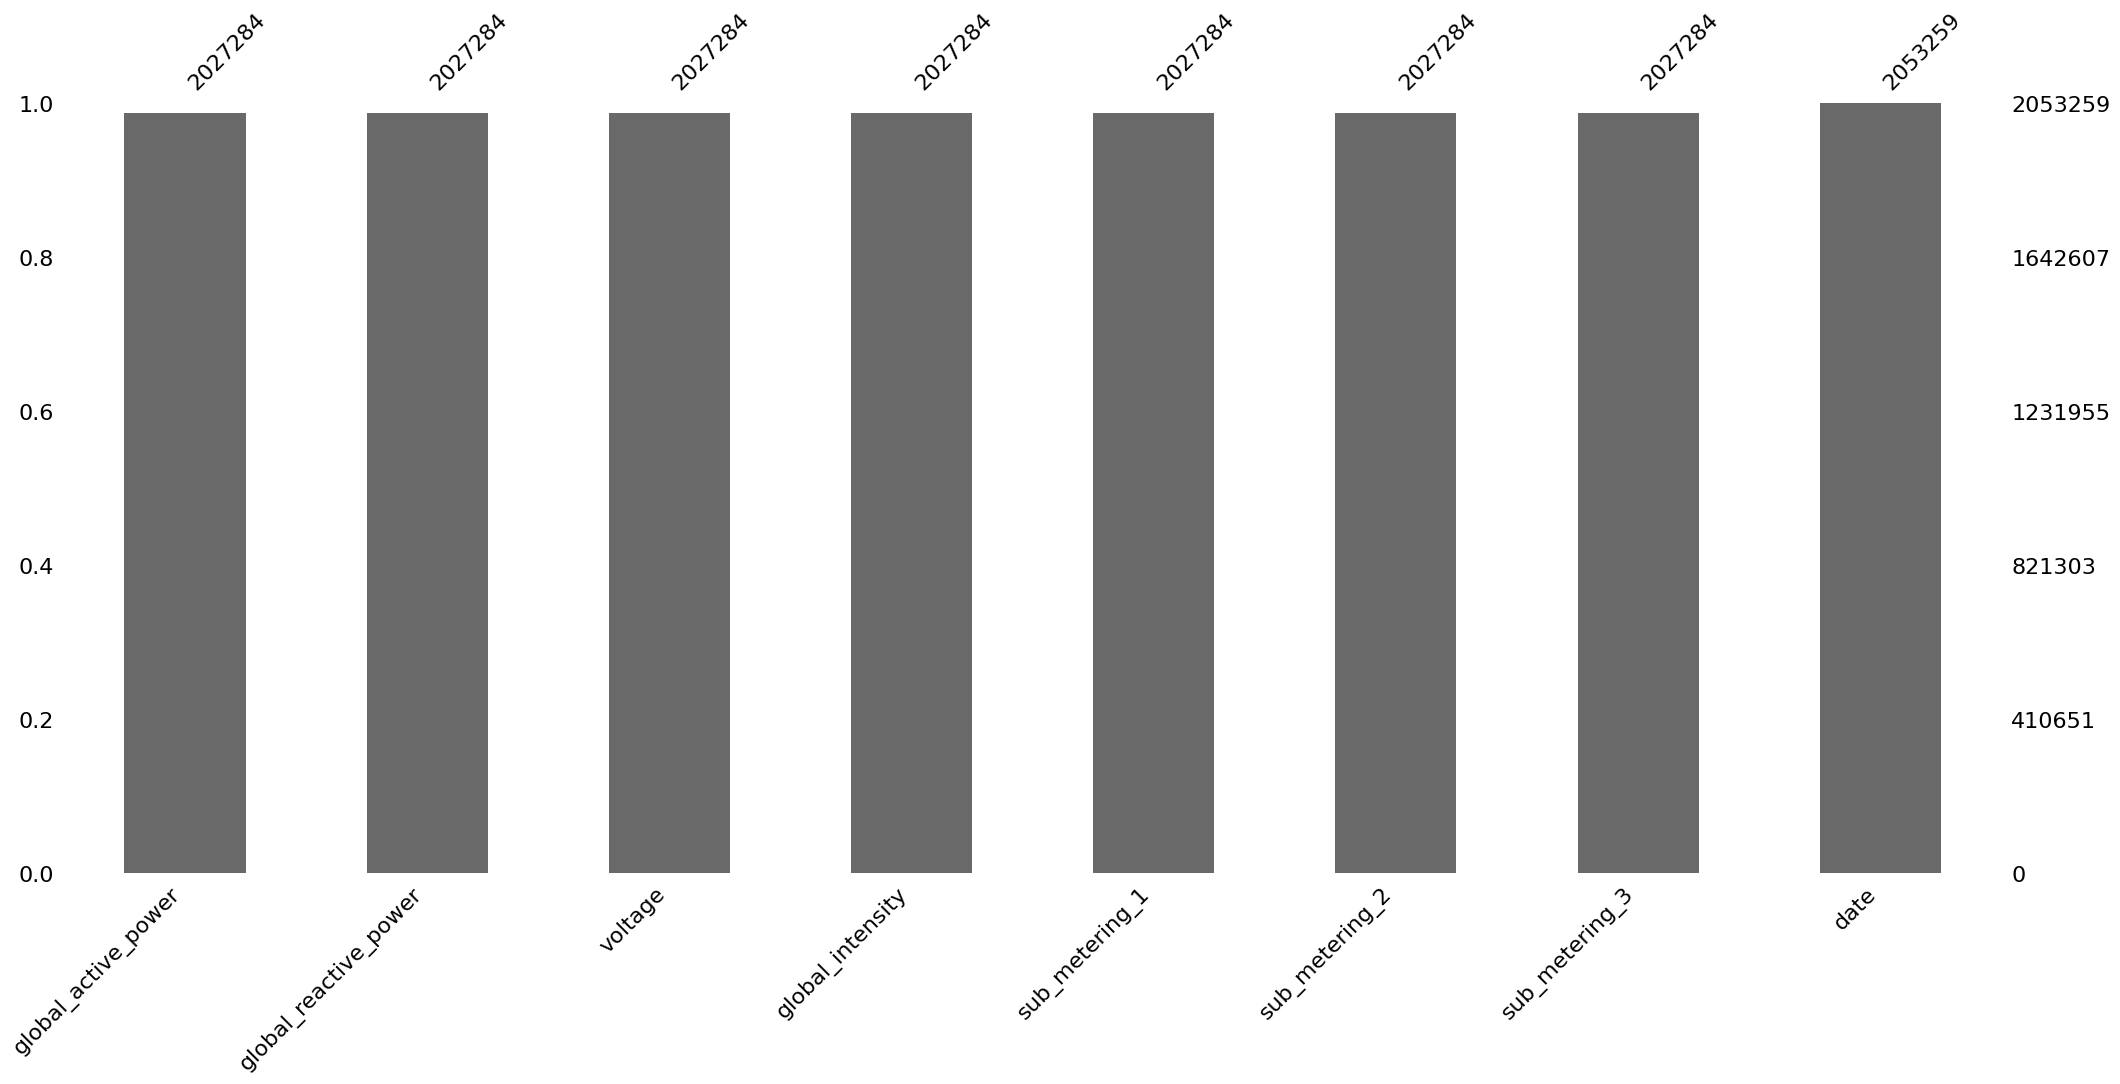

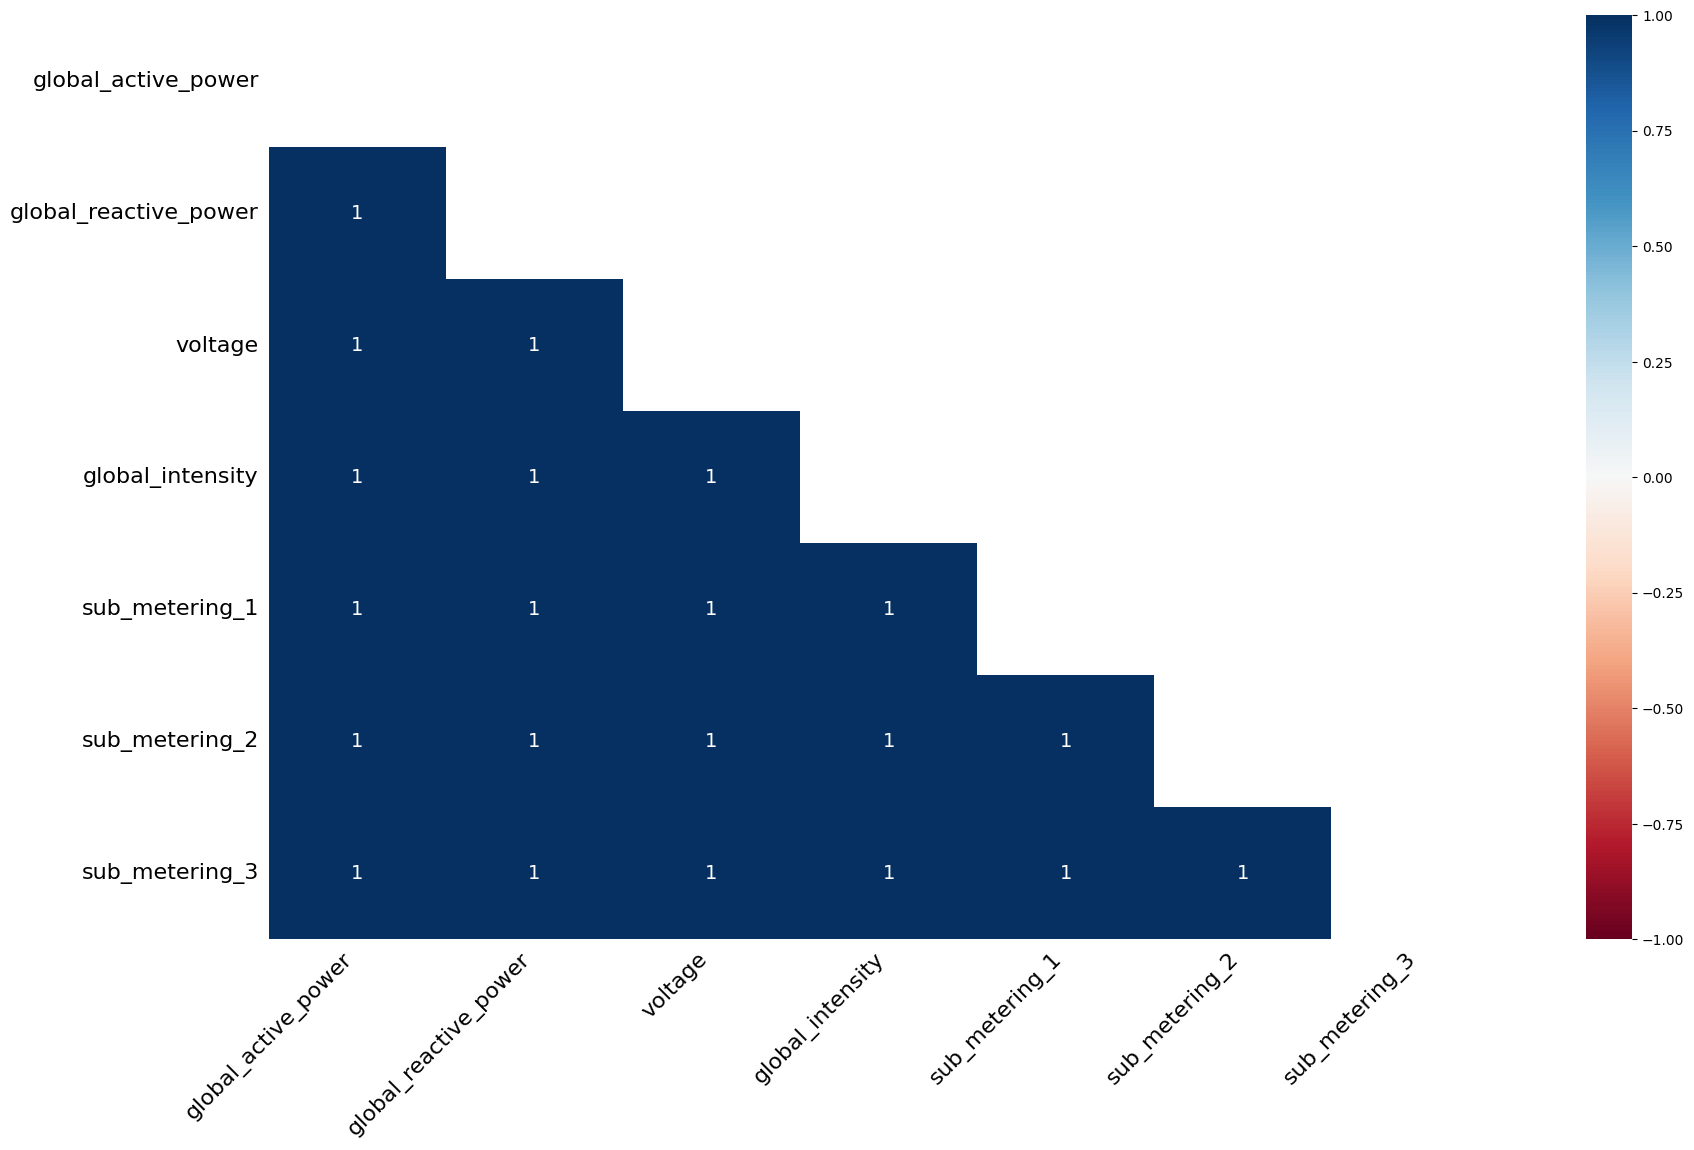

In [8]:
msno.bar(df_household)
msno.heatmap(df_household)

We observe that in the *df_household* dataframe a small percentage of the data is missing and missing values always appear as entire rows. This suggests that we can effectively interpolate missing values.

<Axes: >

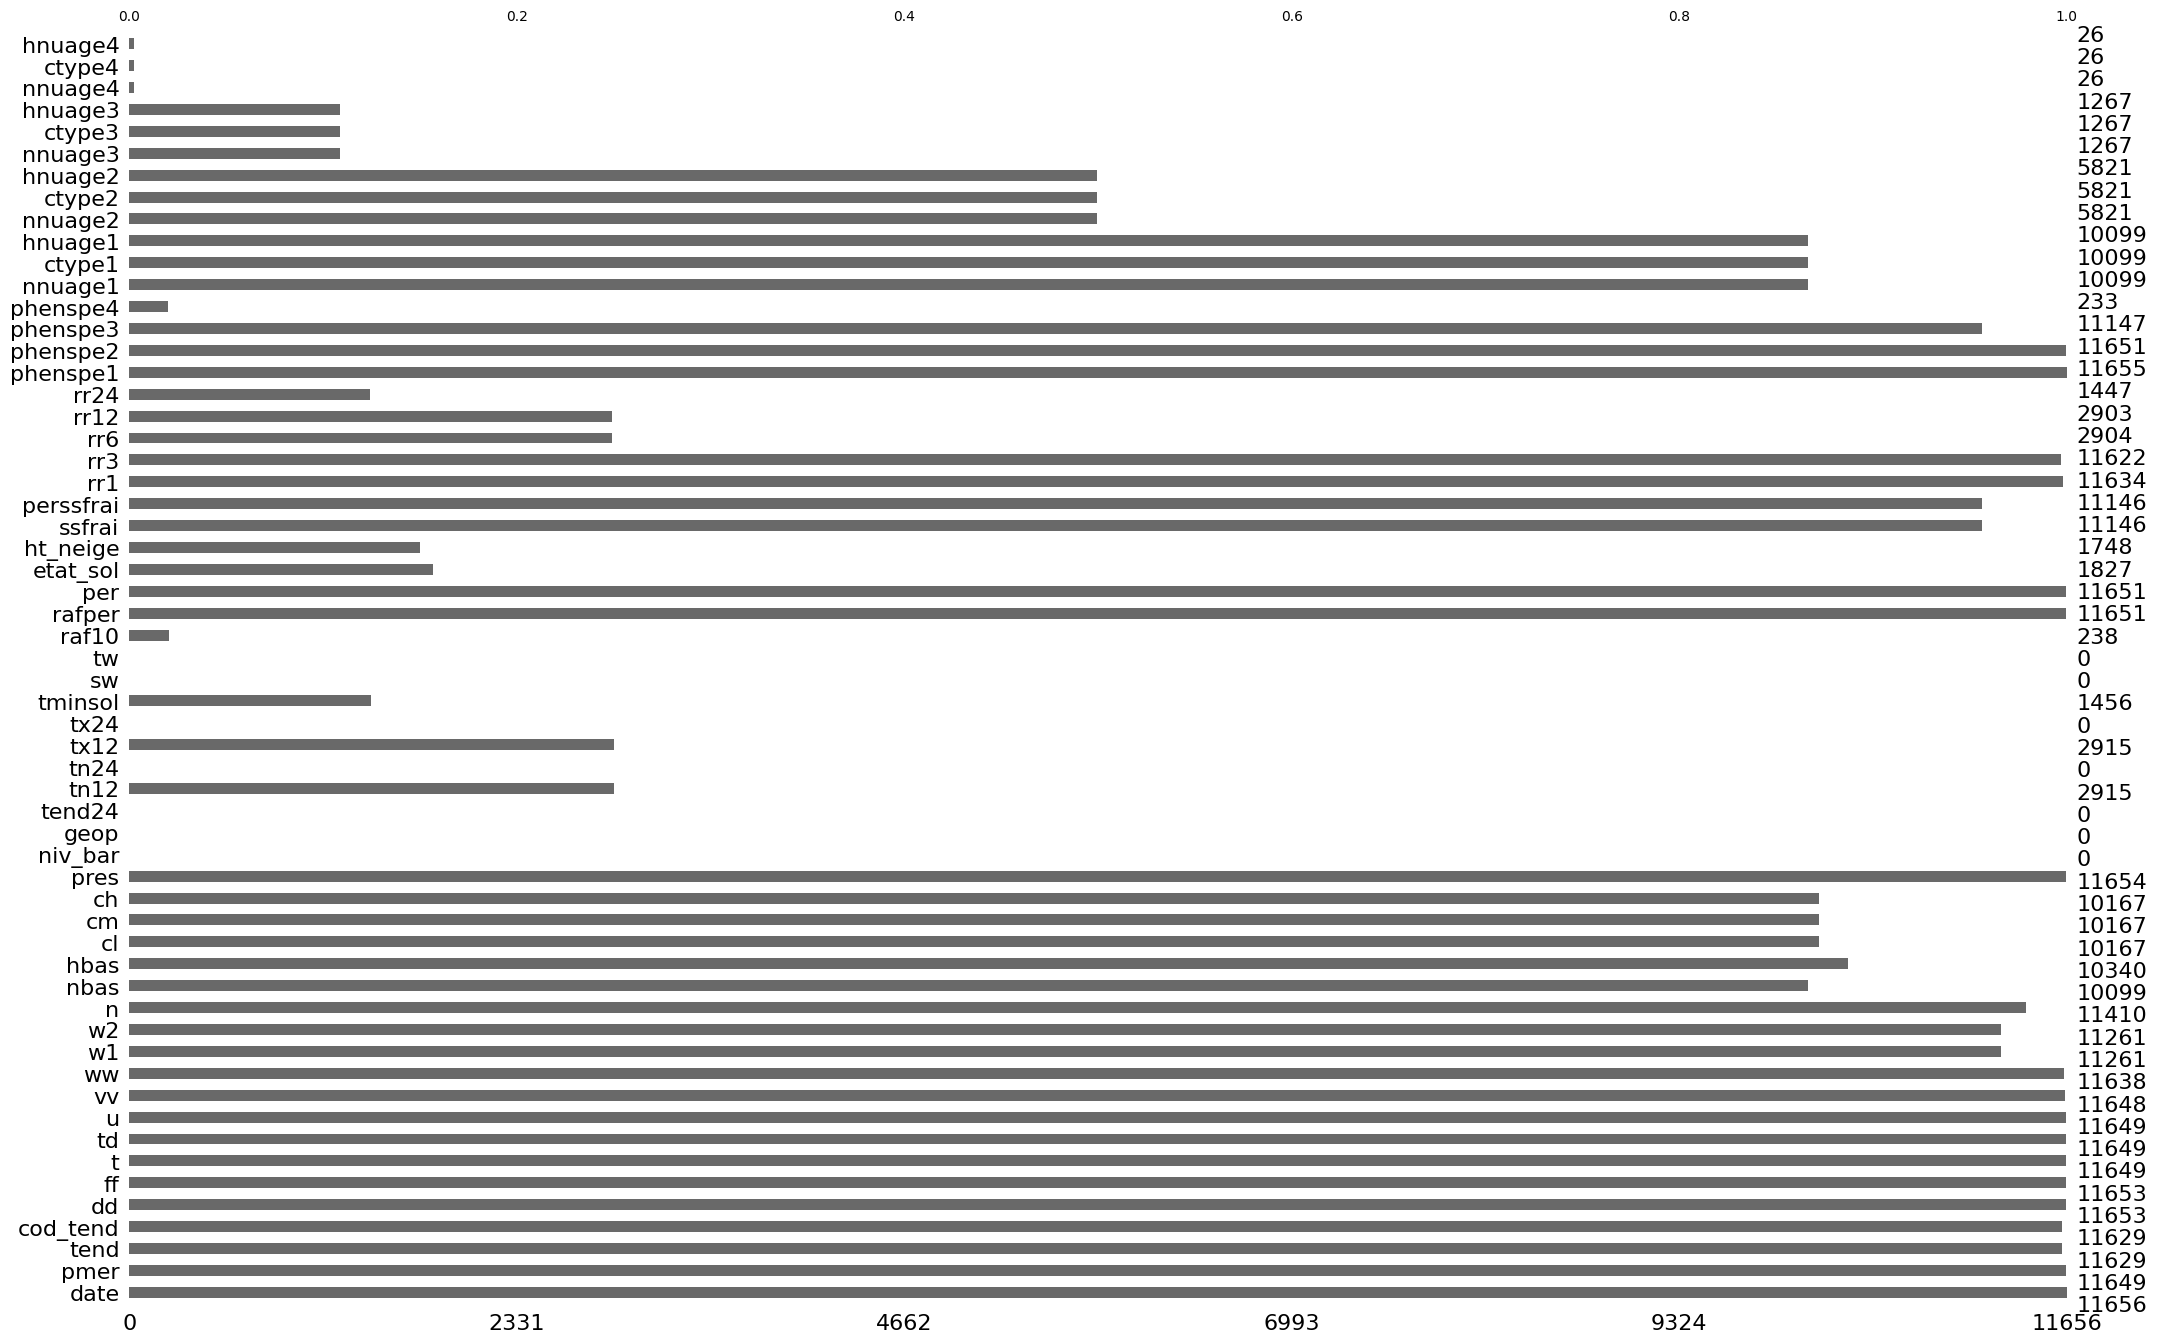

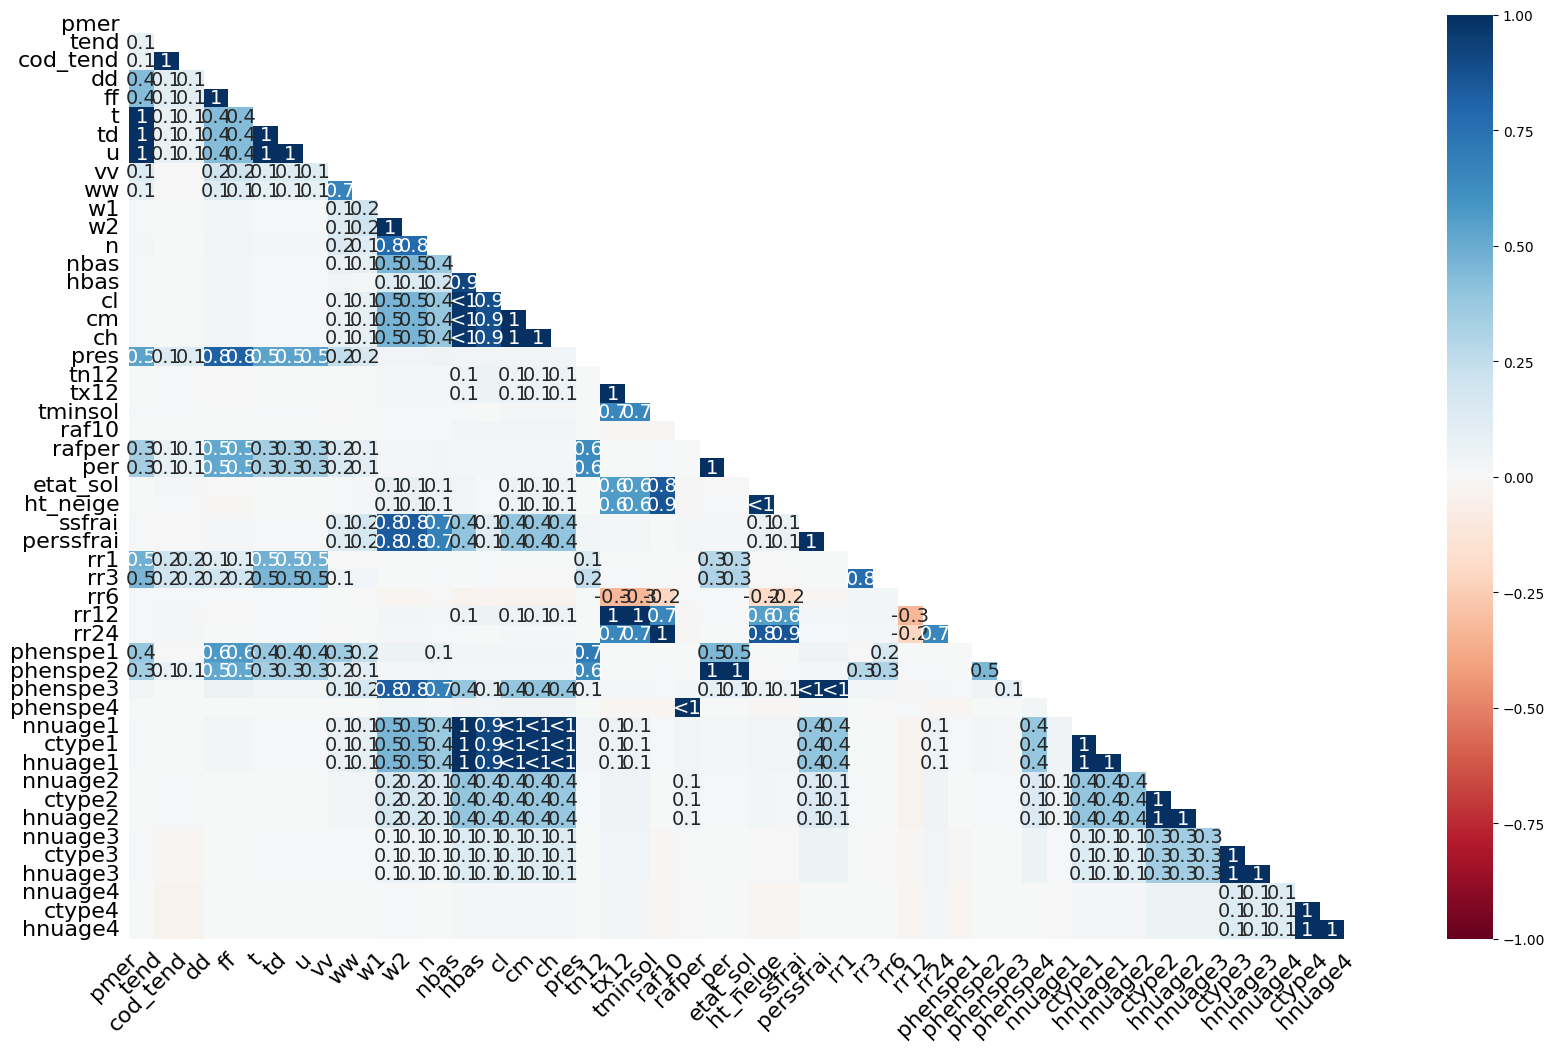

In [9]:
msno.bar(df_station)
msno.heatmap(df_station)

For the *df_station* dataset, the situation is more complicated. We have a bigger amount of missing data and missing values do not always come in blocks as indicated by the heatmap.

<h4 align="center"> <font color='gray'>Interpolating missing data</font></h4> <a class="anchor" id="1.2.2"></a>

We would like to fill rows with missing data in order to keep the structure of our data. Let's use interpolation to fill these missing values.

In [10]:
df_household = df_household.interpolate()
df_station = df_station.interpolate()
df_station = df_station.ffill()
df_station = df_station.bfill()

df_station = df_station.drop('tw', axis=1)
df_station = df_station.drop('sw', axis=1)
df_station = df_station.drop('tx24', axis=1)
df_station = df_station.drop('tn24', axis=1)
df_station = df_station.drop('tend24', axis=1)
df_station = df_station.drop('geop', axis=1)
df_station = df_station.drop('niv_bar', axis=1)

<h4 align="center"> <font color='gray'>Winsorizing outliers</font></h4> <a class="anchor" id="1.2.3"></a>

We start with the household dataset. Let's compute the **z-scores** and visualise their distribution using boxplots. 

In [11]:
# Calculate Z-scores
z_scores = (df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']] - df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].mean()) / df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].std()

# we set the color palette for better visualisation
sns.set(style="whitegrid", palette="pastel")

# we set a convenient figure size
plt.figure(figsize=(10, 6))

# plot boxplots for Z-scores
sns.boxplot(data=z_scores, orient="v")
plt.title('Boxplots of Z-scores for Household Energy Data', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Z-values', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3'], rotation=45)

plt.show()

: 

We observe a large amount of outliers for many of the dataframe's columns. Some outliers are quite extreme and likely represent errors in the sensor data. To eliminate outliers from our dataframe, we use the *winsorization* technique. In other words, we shall fix a z-score threshold and replace values outside this threshold with a maximal/minimal value.

In [ ]:
threshold = 0.997

# Replace values exceeding threshold with values at threshold percentile
df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']] = df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].clip(lower=z_scores.quantile(1-threshold), upper=z_scores.quantile(threshold), axis=1)

Now, we repeat this procedure for the weather station data. Since we have a lot of Let's calculate z-scores and plot the boxplots.

In [ ]:
z_scores2 = (df_station['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'] - df_station['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'].mean())/df_station['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'].std()

df_station['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'] = df_station['pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'].clip(lower=z_scores2.quantile(1-threshold), upper=z_scores2.quantile(threshold), axis=1)


KeyError: ('pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4')

<h2 align="center"> <font color='gray'>Task 2: Seasonality detection</font></h2> <a class="anchor" id="2"></a>

In [ ]:
daily_energy_consumption = df_household[['date', 'global_active_power']]

daily_energy_consumption.set_index('date', inplace=True)

daily_energy_consumption = daily_energy_consumption.resample('D').sum()
daily_energy_consumption *= 60 # we convert power to energy in kJ


# Print or use the structured array
print(daily_energy_consumption)

            global_active_power
date                           
2007-01-01        164785.440000
2007-01-02         76154.160000
2007-01-03         60744.703121
2007-01-04        192239.508657
2007-01-05        161831.596219
...                         ...
2010-11-22        121799.356219
2010-11-23         94649.308747
2010-11-24        107623.418109
2010-11-25         85841.354374
2010-11-26         89286.240000

[1426 rows x 1 columns]


In [ ]:
# Reset the index to move 'date' back into a regular column
daily_energy_consumption.reset_index(inplace=True)

# Convert the 'date' column to datetime format if it's not already
daily_energy_consumption['date'] = pd.to_datetime(daily_energy_consumption['date'])

# Extract the day of the year and assign it to the 'date' column
daily_energy_consumption['date'] = daily_energy_consumption['date'].dt.dayofyear

# Print the entire DataFrame
print(daily_energy_consumption.to_string(index=False))


 date  global_active_power
    1        164785.440000
    2         76154.160000
    3         60744.703121
    4        192239.508657
    5        161831.596219
    6         89429.591208
    7        139361.387336
    8        134459.354374
    9        108950.185581
   10        127086.654328
   11        131565.318064
   12         87285.011868
   13        176094.398498
   14        176283.559249
   15        128603.589362
   16        100978.749362
   17        167277.044306
   18        108874.120615
   19         88548.834989
   20        180533.699864
   21        187588.833487
   22        128301.078064
   23        105952.288087
   24        177282.339955
   25         95141.812483
   26         97046.068747
   27        120806.065581
   28        182020.877404
   29        118785.995604
   30        101064.505581
   31        140143.830592
   32        108721.350592
   33         99997.468747
   34        230336.600434
   35        209837.546106
   36         98022.625581
 

In [ ]:
scaler = StandardScaler()
scaled_daily_energy_consumption = scaler.fit_transform(daily_energy_consumption)

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(scaled_daily_energy_consumption)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

We will use the Elbow method to determine the optimal number of clusters.

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

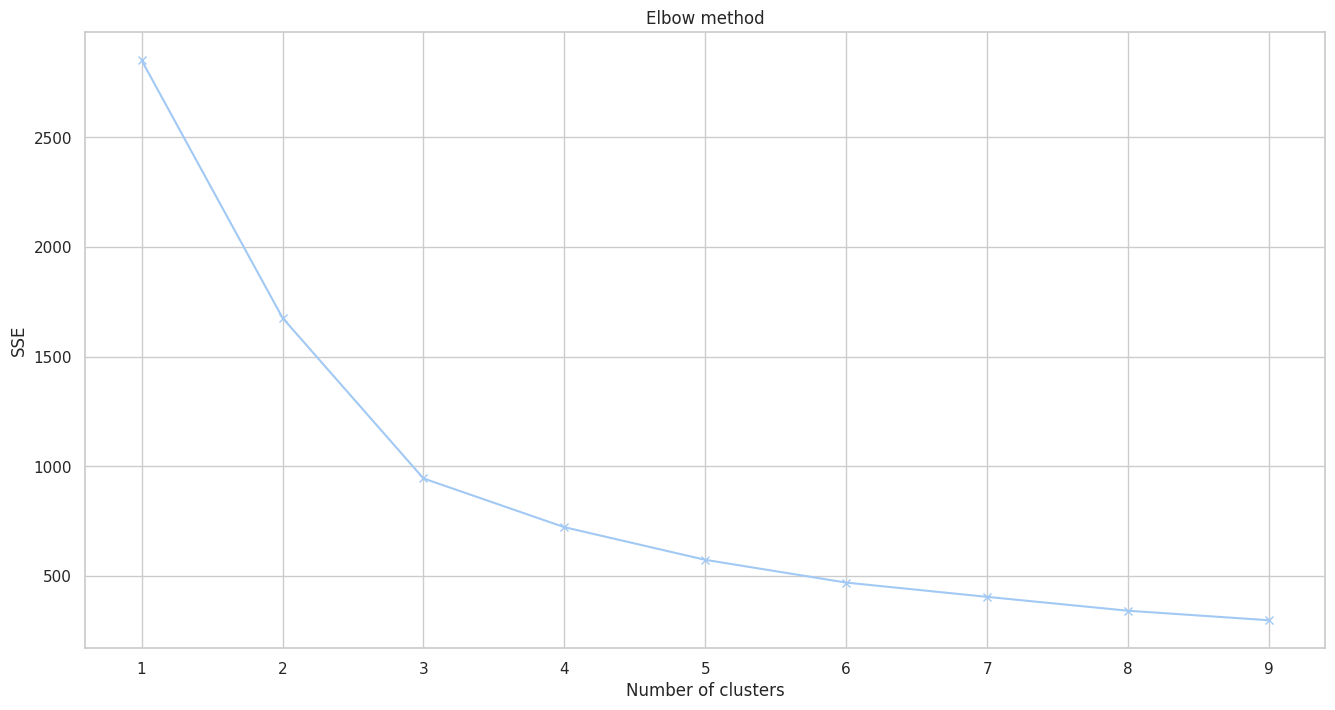

In [ ]:
sse = []
k_vals = range(1,10)
for k in k_vals:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_daily_energy_consumption)
    sse.append(kmeanModel.inertia_)
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(k_vals, sse, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow method")
plt.show()

In [ ]:
kl = KneeLocator(k_vals, sse, curve="convex", direction="decreasing")

print(kl.elbow)

3


In [ ]:
# Define the model
kmeans_model = KMeans(n_clusters=3, random_state=32932)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(scaled_daily_energy_consumption)
daily_energy_consumption['cluster'] = kmeans_predict

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


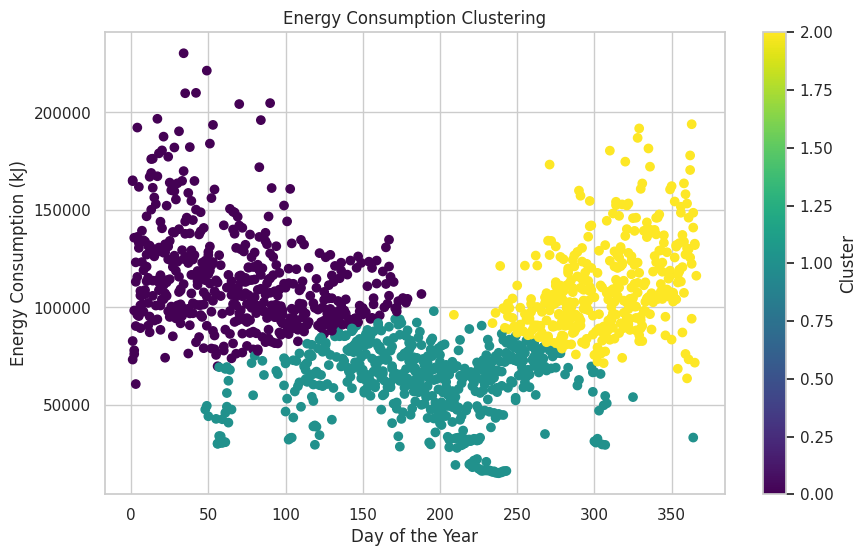

In [ ]:
# Scatter plot the points in daily_energy_consumption DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(daily_energy_consumption['date'], daily_energy_consumption['global_active_power'], c=kmeans_predict, cmap='viridis')
plt.title('Energy Consumption Clustering')
plt.xlabel('Day of the Year')
plt.ylabel('Energy Consumption (kJ)')
plt.colorbar(label='Cluster')
plt.show()

<h2 align="center"> <font color='gray'>Task 3: Distribution of hourly consumption</font></h2> <a class="anchor" id="3"></a>

In [ ]:
hourly_energy_consumption = df_household[['date', 'global_active_power']]

hourly_energy_consumption.set_index('date', inplace=True)

hourly_energy_consumption = hourly_energy_consumption.resample('H').sum()
hourly_energy_consumption *= 60 # we convert power to energy in kJ


# Print or use the structured array
print(hourly_energy_consumption)

                     global_active_power
date                                    
2007-01-01 00:00:00              9027.48
2007-01-01 01:00:00              9084.24
2007-01-01 02:00:00              9296.40
2007-01-01 03:00:00              9150.00
2007-01-01 04:00:00              8912.64
...                                  ...
2010-11-26 17:00:00              6213.24
2010-11-26 18:00:00              5664.48
2010-11-26 19:00:00              5973.60
2010-11-26 20:00:00              4189.32
2010-11-26 21:00:00               168.24

[34222 rows x 1 columns]


In [ ]:
# Reset the index to move 'date' back into a regular column
hourly_energy_consumption.reset_index(inplace=True)

# Convert the 'date' column to datetime format if it's not already
hourly_energy_consumption['date'] = pd.to_datetime(hourly_energy_consumption['date'])

# Extract the day of the year and assign it to the 'date' column
hourly_energy_consumption['hour'] = hourly_energy_consumption['date'].dt.hour

hourly_energy_consumption['day'] = hourly_energy_consumption['date'].dt.dayofyear

hourly_energy_consumption['year'] = hourly_energy_consumption['date'].dt.year


hourly_energy_consumption.set_index('date', inplace=True)

# Print the entire DataFrame
print(hourly_energy_consumption.to_string(index=False))

 global_active_power  hour  day  year
         9027.480000     0    1  2007
         9084.240000     1    1  2007
         9296.400000     2    1  2007
         9150.000000     3    1  2007
         8912.640000     4    1  2007
         8914.440000     5    1  2007
         8840.880000     6    1  2007
         8809.920000     7    1  2007
         8790.240000     8    1  2007
        11326.080000     9    1  2007
         9582.240000    10    1  2007
         9273.600000    11    1  2007
         9417.120000    12    1  2007
         7784.640000    13    1  2007
         4659.840000    14    1  2007
         6873.000000    15    1  2007
         5004.360000    16    1  2007
         5875.440000    17    1  2007
         5262.840000    18    1  2007
         2636.280000    19    1  2007
         1484.280000    20    1  2007
         1562.160000    21    1  2007
         1597.440000    22    1  2007
         1619.880000    23    1  2007
         1607.160000     0    2  2007
         157

In [ ]:
# Filter the dataset for days with label 20, 200, and 340
day_20_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 20) & (hourly_energy_consumption['year'] == 2007)]
day_200_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 200) & (hourly_energy_consumption['year'] == 2007)]
day_340_samples = hourly_energy_consumption[(hourly_energy_consumption['day'] == 340) & (hourly_energy_consumption['year'] == 2007)]


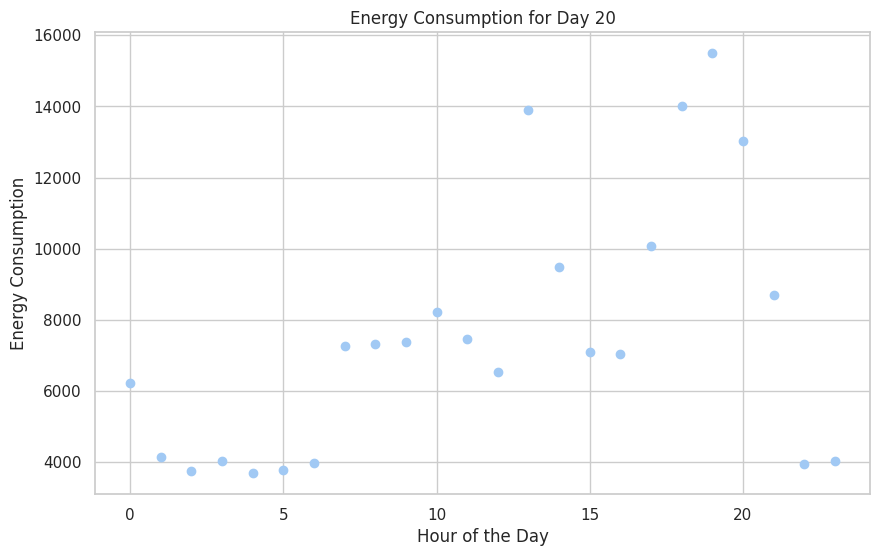

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_20_samples['hour'], day_20_samples['global_active_power'])
plt.title('Energy Consumption for Day 20')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

Kolmogorov-Smirnov test result: KstestResult(statistic=0.17235398213698333, pvalue=0.42605286626423833, statistic_location=7472.16, statistic_sign=1)


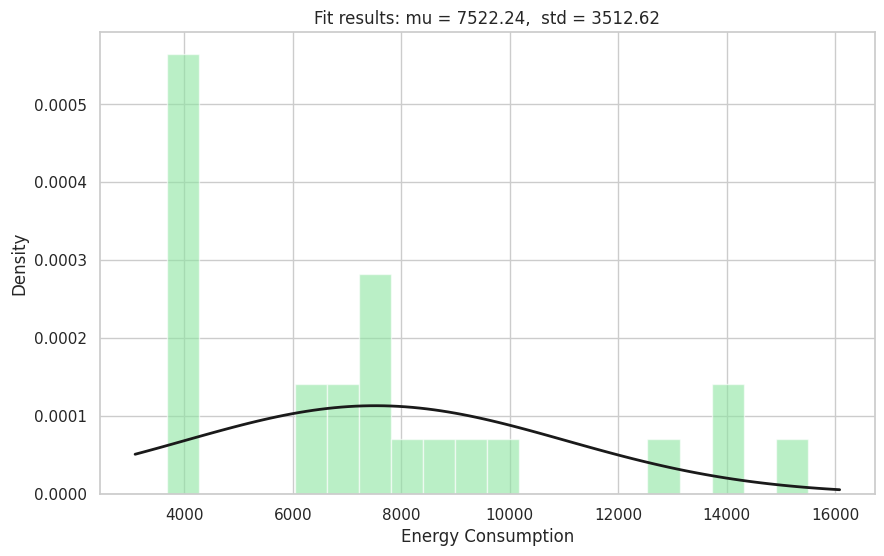

In [ ]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_20_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_20_samples['global_active_power'], bins=20, density=True, alpha=0.6, color='g')

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Fit results: mu = %.2f,  std = %.2f' % (mu, std))
plt.xlabel('Energy Consumption')
plt.ylabel('Density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_20_samples['global_active_power'], 'norm', args=(mu, std))
print("Kolmogorov-Smirnov test result:", kstest_result)

plt.show()

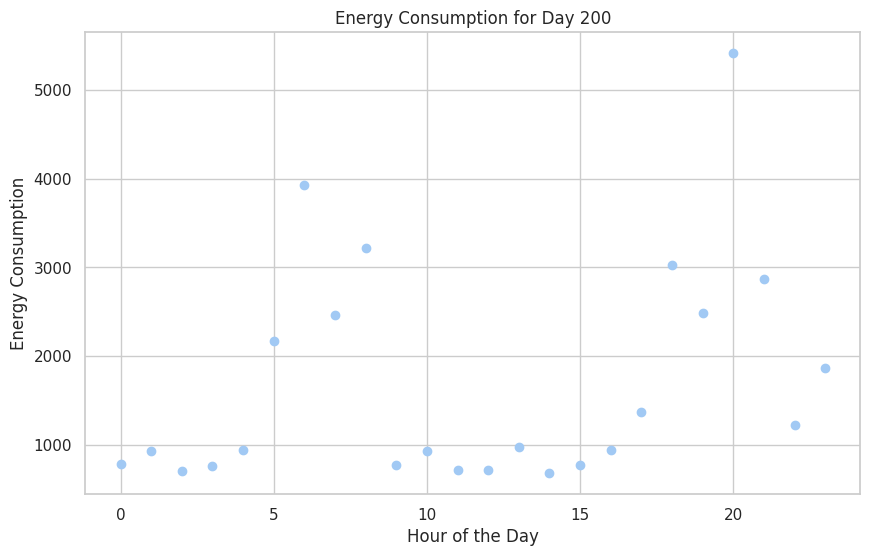

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_200_samples['hour'], day_200_samples['global_active_power'])
plt.title('Energy Consumption for Day 200')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

Kolmogorov-Smirnov test result: KstestResult(statistic=0.26273391888102865, pvalue=0.05964796429090269, statistic_location=973.1999999999999, statistic_sign=1)


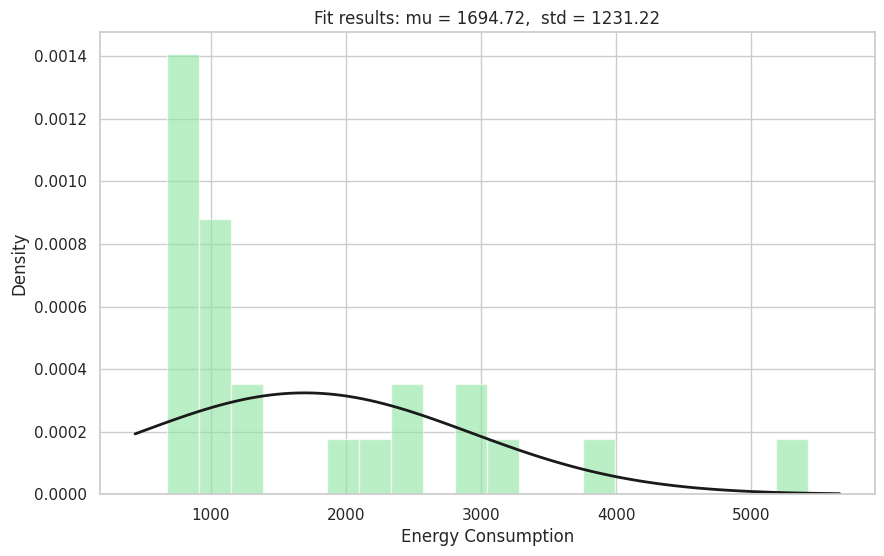

In [ ]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_200_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_200_samples['global_active_power'], bins=20, density=True, alpha=0.6, color='g')

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Fit results: mu = %.2f,  std = %.2f' % (mu, std))
plt.xlabel('Energy Consumption')
plt.ylabel('Density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_200_samples['global_active_power'], 'norm', args=(mu, std))
print("Kolmogorov-Smirnov test result:", kstest_result)

plt.show()

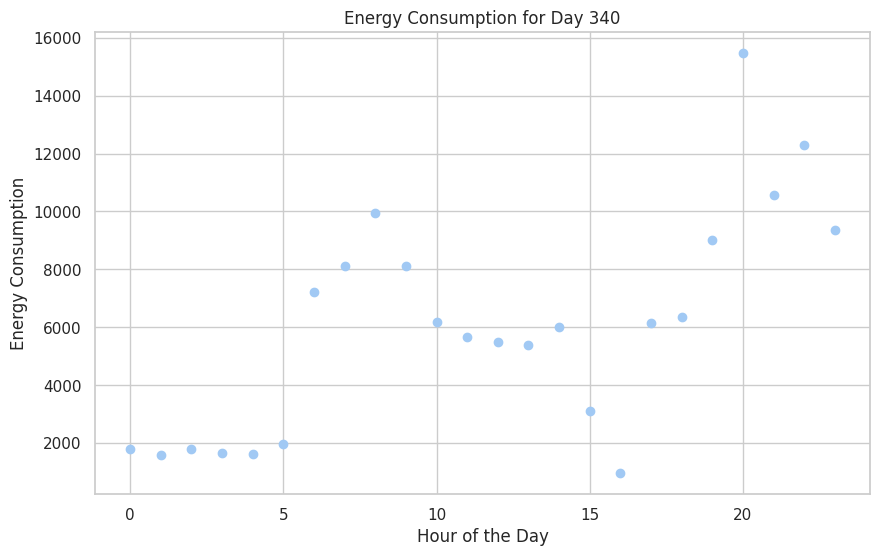

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(day_340_samples['hour'], day_340_samples['global_active_power'])
plt.title('Energy Consumption for Day 340')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

Kolmogorov-Smirnov test result: KstestResult(statistic=0.15467632243715812, pvalue=0.5619328150523923, statistic_location=1968.48, statistic_sign=1)


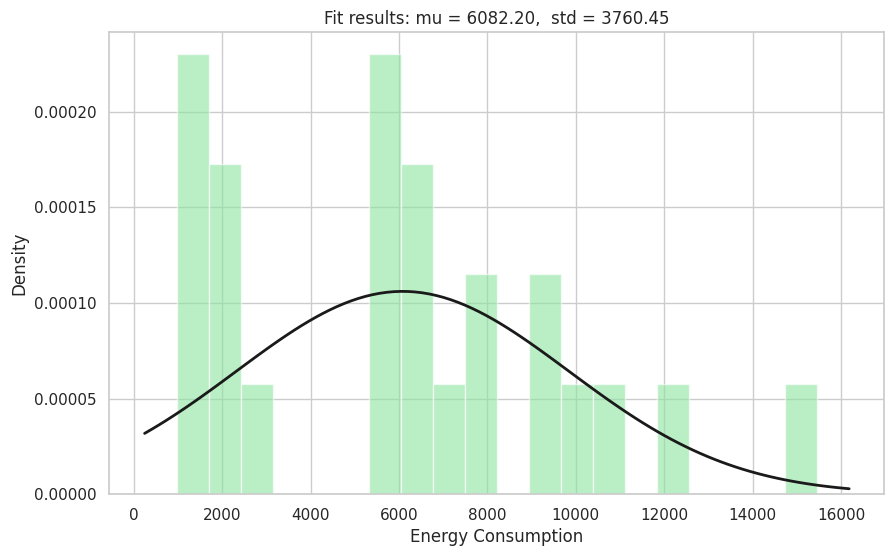

In [ ]:
# Fit a Gaussian distribution to the data
mu, std = norm.fit(day_340_samples['global_active_power'])

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(day_340_samples['global_active_power'], bins=20, density=True, alpha=0.6, color='g')

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.title('Fit results: mu = %.2f,  std = %.2f' % (mu, std))
plt.xlabel('Energy Consumption')
plt.ylabel('Density')

# Perform Kolmogorov-Smirnov test
kstest_result = kstest(day_340_samples['global_active_power'], 'norm', args=(mu, std))
print("Kolmogorov-Smirnov test result:", kstest_result)

plt.show()

TASK 4: PREDICTION!!!!!!!!!!!!!!!!

In [ ]:
# Print the entire DataFrame
print(df_station.to_string(index=False))